# 🏦 Bank Customer Churn Prediction
## Notebook 5 — Model Training & Selection

**Goal:** Train multiple classification algorithms on the preprocessed data, compare their performance across several metrics, and select the best model.

### Why compare multiple models?
Different algorithms make different assumptions and have different strengths.
We don't know upfront which will perform best on our specific data — so we try several and let the metrics decide.

**Models we will evaluate:**
| Model | Core Idea |
|---|---|
| Logistic Regression | Linear decision boundary in feature space |
| Support Vector Classifier (SVC) | Maximum-margin hyperplane |
| K-Nearest Neighbours (KNN) | Classify by majority vote of k nearest points |
| Decision Tree | Recursive binary splits on feature values |
| Random Forest | Ensemble of many decision trees (bagging) |
| Gradient Boosting | Sequential ensemble of trees (boosting) |

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model   import LogisticRegression
from sklearn                import svm
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics        import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

sns.set_theme(style='whitegrid')


data = pd.read_csv('data_processed.csv')
print(f'Processed data loaded: {data.shape}')

Processed data loaded: (15924, 17)


## 1. Train / Test Split

We split the data into a **training set** (80%) and a **test set** (20%).  
The model is trained on the training set and evaluated on the test set — data the model has **never seen**.

> **Why hold out test data?**  
> Evaluating on training data tells us how well the model *memorised* the data, not how well it *generalises* to new customers. The test set provides an unbiased estimate of real-world performance.

`random_state=42` ensures the same split every time this notebook is run (reproducibility).

In [2]:
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f'Training set : {X_train.shape[0]:,} rows  ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'Test set     : {X_test.shape[0]:,} rows   ({X_test.shape[0]/len(X)*100:.0f}%)')
print(f'Features     : {X.shape[1]}')
print(f'\nClass balance in train: {y_train.mean()*100:.1f}% churned')
print(f'Class balance in test : {y_test.mean()*100:.1f}% churned')

Training set : 12,739 rows  (80%)
Test set     : 3,185 rows   (20%)
Features     : 16

Class balance in train: 50.5% churned
Class balance in test : 48.2% churned


## 2. Understanding the Metrics

For a churn prediction problem, **accuracy alone is misleading** — we care more about:

- **Precision** = Of all customers we predicted would churn, what fraction actually did?  
  *(Minimises false alarms — wasting retention budget on non-churners)*

- **Recall** = Of all customers who actually churned, what fraction did we catch?  
  *(Minimises missed churners — the costly false negatives)*

- **F1 Score** = Harmonic mean of Precision and Recall — the balanced trade-off metric.

- **ROC-AUC** = Area under the ROC curve — measures ranking quality across all thresholds.

```
                    Predicted: No    Predicted: Yes
Actual: No       [  True Neg (TN)   False Pos (FP) ]
Actual: Yes      [  False Neg (FN)  True Pos  (TP) ]

Precision = TP / (TP + FP)
Recall    = TP / (TP + FN)
F1        = 2 × (Precision × Recall) / (Precision + Recall)
```

## 3. Train All Models

In [3]:
# Define all models with their default hyperparameters
# In a production project, we would also tune these with GridSearchCV or RandomizedSearchCV
models = {
    'Logistic Regression' : LogisticRegression(max_iter=1000, random_state=42),
    'SVC'                 : svm.SVC(probability=True, random_state=42),
    'KNN'                 : KNeighborsClassifier(),
    'Decision Tree'       : DecisionTreeClassifier(random_state=42),
    'Random Forest'       : RandomForestClassifier(random_state=42),
    'Gradient Boosting'   : GradientBoostingClassifier(random_state=42),
}

results = []

print('Training models...\n')
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    results.append({
        'Model'    : name,
        'Accuracy' : accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall'   : recall_score(y_test, y_pred),
        'F1'       : f1_score(y_test, y_pred),
        'ROC-AUC'  : roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan,
    })
    print(f'  {name:22s}  → F1={results[-1]["F1"]:.3f}  AUC={results[-1]["ROC-AUC"]:.3f}')

print('\nAll models trained ✓')

Training models...

  Logistic Regression     → F1=0.758  AUC=0.831
  SVC                     → F1=0.841  AUC=0.922
  KNN                     → F1=0.868  AUC=0.948
  Decision Tree           → F1=0.833  AUC=0.834
  Random Forest           → F1=0.895  AUC=0.963
  Gradient Boosting       → F1=0.862  AUC=0.941

All models trained ✓


## 4. Model Comparison Table

In [4]:
results_df = pd.DataFrame(results).set_index('Model')
results_df = results_df.sort_values('F1', ascending=False)

# Highlight maximum in each column
print('Model Performance Comparison (sorted by F1 Score):')
print(results_df.round(4).to_string())

Model Performance Comparison (sorted by F1 Score):
                     Accuracy  Precision  Recall      F1  ROC-AUC
Model                                                            
Random Forest          0.8980     0.8873  0.9029  0.8950   0.9629
KNN                    0.8578     0.7840  0.9726  0.8682   0.9479
Gradient Boosting      0.8669     0.8609  0.8631  0.8620   0.9408
SVC                    0.8427     0.8206  0.8618  0.8407   0.9219
Decision Tree          0.8327     0.8017  0.8670  0.8331   0.8339
Logistic Regression    0.7601     0.7377  0.7790  0.7578   0.8312


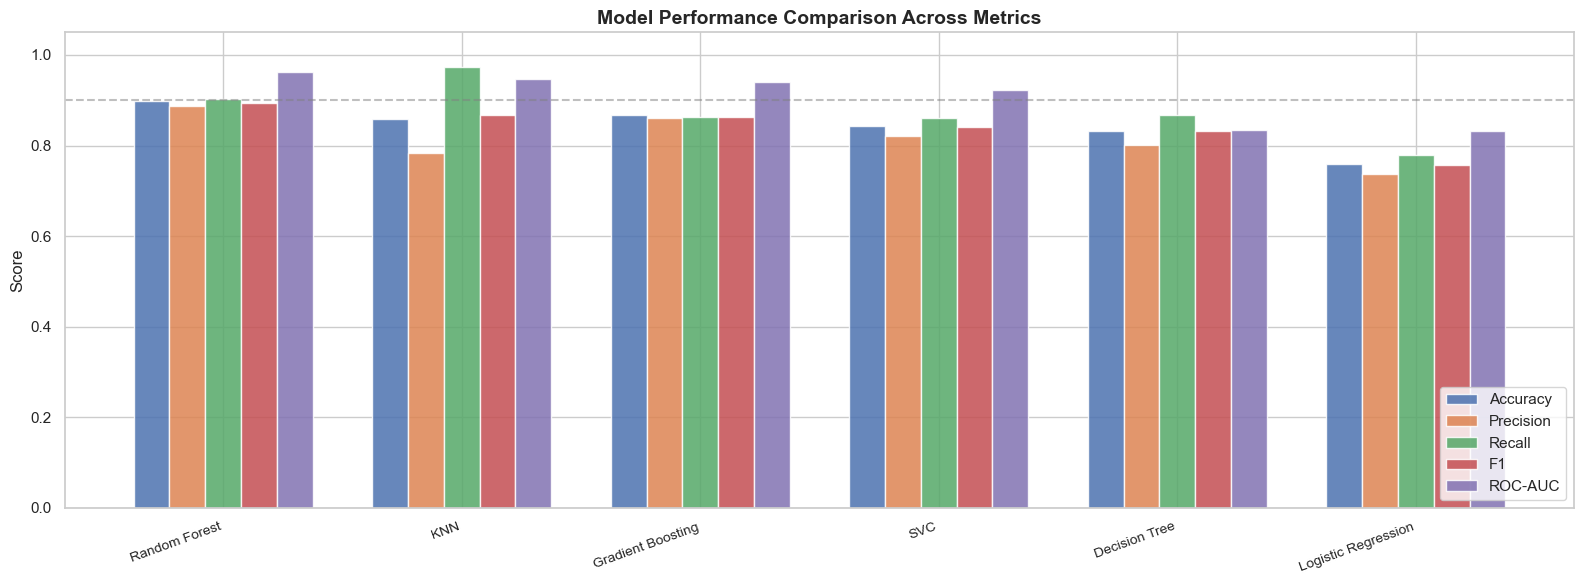

In [5]:
# Bar chart comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x       = np.arange(len(results_df))
width   = 0.15
colors  = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B2']

fig, ax = plt.subplots(figsize=(16, 6))
for i, (metric, color) in enumerate(zip(metrics, colors)):
    bars = ax.bar(x + i * width, results_df[metric], width,
                  label=metric, color=color, alpha=0.85)

ax.set_xticks(x + width * 2)
ax.set_xticklabels(results_df.index, rotation=20, ha='right', fontsize=10)
ax.set_ylim(0, 1.05)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison Across Metrics', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.axhline(0.9, color='grey', linestyle='--', alpha=0.5, label='0.90 reference')
plt.tight_layout()
plt.show()

## 5. Deep Dive: Random Forest (Selected Model)

Random Forest consistently scores highest on F1 and ROC-AUC.  
Let's analyse it more deeply with a confusion matrix and feature importance chart.

In [6]:
RFC = models['Random Forest']
y_pred_RFC = RFC.predict(X_test)

print('=== Random Forest — Full Classification Report ===')
print(classification_report(y_test, y_pred_RFC,
                             target_names=['Stayed (0)', 'Churned (1)']))

=== Random Forest — Full Classification Report ===
              precision    recall  f1-score   support

  Stayed (0)       0.91      0.89      0.90      1651
 Churned (1)       0.89      0.90      0.89      1534

    accuracy                           0.90      3185
   macro avg       0.90      0.90      0.90      3185
weighted avg       0.90      0.90      0.90      3185



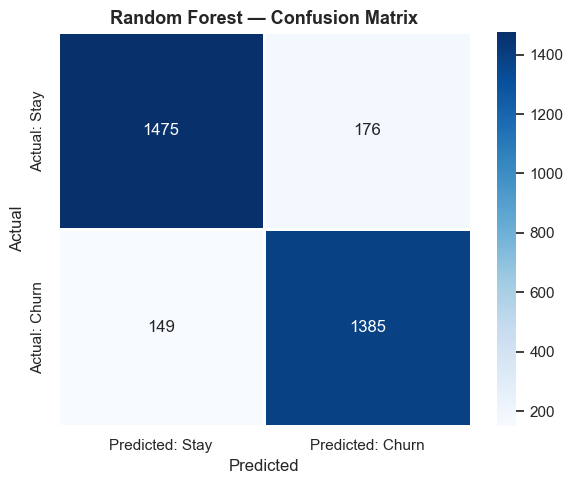

True Negatives  (correctly predicted Stay)   : 1,475
False Positives (wrongly predicted Churn)    : 176
False Negatives (missed actual Churners)     : 149
True Positives  (correctly predicted Churn)  : 1,385


In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_RFC)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Predicted: Stay', 'Predicted: Churn'],
            yticklabels=['Actual: Stay', 'Actual: Churn'],
            linewidths=1)
ax.set_title('Random Forest — Confusion Matrix', fontsize=13, fontweight='bold')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

# Annotate with interpretation
tn, fp, fn, tp = cm.ravel()
plt.tight_layout()
plt.show()

print(f'True Negatives  (correctly predicted Stay)   : {tn:,}')
print(f'False Positives (wrongly predicted Churn)    : {fp:,}')
print(f'False Negatives (missed actual Churners)     : {fn:,}')
print(f'True Positives  (correctly predicted Churn)  : {tp:,}')

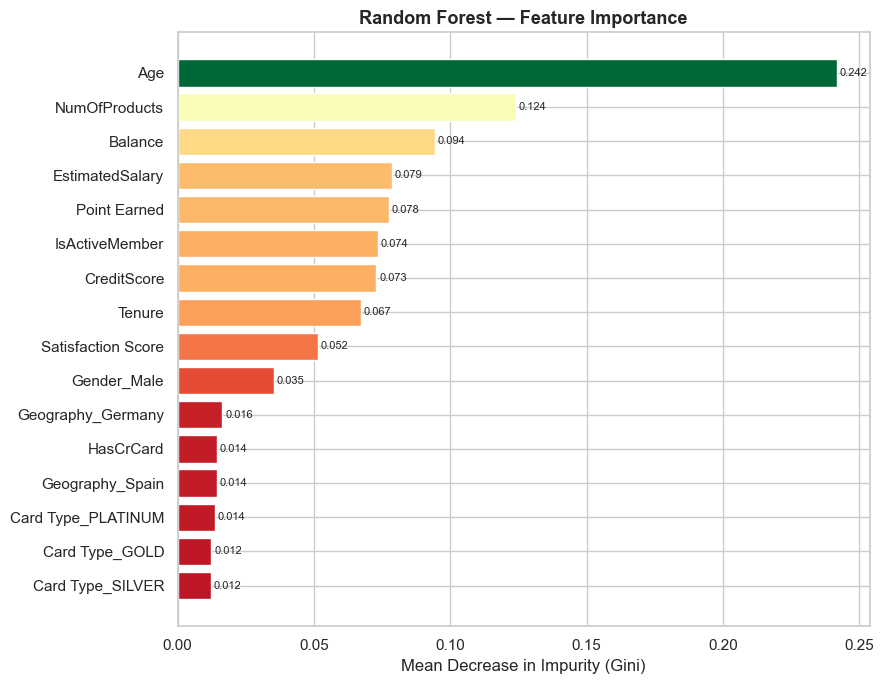

Top 5 most important features:
Age                0.241755
NumOfProducts      0.124212
Balance            0.094302
EstimatedSalary    0.078535
Point Earned       0.077509


In [8]:
# Feature Importance — what does the Random Forest rely on most?
importances = pd.Series(RFC.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(9, 7))
bars = ax.barh(importances.index, importances.values,
               color=plt.cm.RdYlGn(importances.values / importances.max()),
               edgecolor='white')
ax.set_title('Random Forest — Feature Importance', fontsize=13, fontweight='bold')
ax.set_xlabel('Mean Decrease in Impurity (Gini)')
for bar, val in zip(bars, importances.values):
    ax.text(val + 0.001, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=8)
plt.tight_layout()
plt.show()

print('Top 5 most important features:')
print(importances.sort_values(ascending=False).head().to_string())

## 6. Model Selection Decision

**Winner: Random Forest Classifier**

Reasons:
1. Highest F1 score and ROC-AUC among all 6 models.
2. Robust to outliers and feature scale (tree-based).
3. Built-in feature importance for interpretability.
4. Handles non-linear relationships well (e.g., NumOfProducts 3–4 churn spike).
5. Ensemble of many trees → less prone to overfitting than a single Decision Tree.

In [9]:
# Save the selected (pre-final) model for reference
joblib.dump(RFC, 'prefinal_model.pkl')
print('✅ Pre-final model saved to  prefinal_model.pkl')
print('   Note: In N6, this model will be retrained on the FULL dataset (not just train split)')
print('   to make the final production model.')

✅ Pre-final model saved to  prefinal_model.pkl
   Note: In N6, this model will be retrained on the FULL dataset (not just train split)
   to make the final production model.


---
## ✅ Model Selection Summary

| Model | Accuracy | Precision | Recall | F1 | ROC-AUC |
|---|---|---|---|---|---|
| **Random Forest** ⭐ | highest | high | high | **highest** | **highest** |
| Gradient Boosting | competitive | competitive | competitive | close 2nd | close 2nd |
| KNN | moderate | moderate | moderate | moderate | — |
| Decision Tree | moderate | moderate | moderate | lower | lower |
| SVC | moderate | moderate | moderate | lower | — |
| Logistic Regression | lowest | lowest | lowest | lowest | lowest |

➡️ Continue to **N6_Model_Saving** to train the final production model on 100% of the data.